In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

## Generate Dataset

In [9]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, 
                          n_redundant=5, random_state=42)

# Training (60%): Para entrenar el modelo
# Validation (20%): Para evaluar y seleccionar hiperparámetros
# Test (20%): Para evaluación final (no se toca hasta el final)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 600 samples
Validation set: 200 samples
Test set: 200 samples


## Method 1: Holdout Validation

Tune hyperparameter (max_depth) using a single validation set

In [ ]:
max_depths = range(1, 21)
train_scores_holdout = []
val_scores_holdout = []

for depth in max_depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    
    train_scores_holdout.append(accuracy_score(y_train, model.predict(X_train)))
    val_scores_holdout.append(accuracy_score(y_val, model.predict(X_val)))

# valor del hiperparámetro que da mejor resultado en validación holdout
best_depth_holdout = max_depths[np.argmax(val_scores_holdout)]
print(f"Best max_depth (Holdout): {best_depth_holdout}")
print(f"Validation accuracy: {max(val_scores_holdout):.3f}")

Best max_depth (Holdout): 4
Validation accuracy: 0.810


## Method 2: Cross-Validation

Tune hyperparameter using k-fold cross-validation (more robust)

In [13]:
max_depths = range(1, 21)
mean_scores_cv = []
std_scores_cv = []
cv_val = 5

# Divide X_train_full en 5 partes para hacer 5 entrenamientos 
# y validaciones internas
# v1: entrena con [2,3,4,5] y valida con [1]
# v2: entrena con [1,3,4,5] y valida con [2]
# ...

for depth in max_depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    scores = cross_val_score(model, X_train_full, y_train_full, cv=cv_val)
    mean_scores_cv.append(scores.mean())
    std_scores_cv.append(scores.std())

best_depth_cv = max_depths[np.argmax(mean_scores_cv)]
print(f"Best max_depth (Cross-Val): {best_depth_cv}")
print(f"CV accuracy: {max(mean_scores_cv):.3f} ± {std_scores_cv[np.argmax(mean_scores_cv)]:.3f}")

Best max_depth (Cross-Val): 6
CV accuracy: 0.785 ± 0.025


## Comparison Visualization

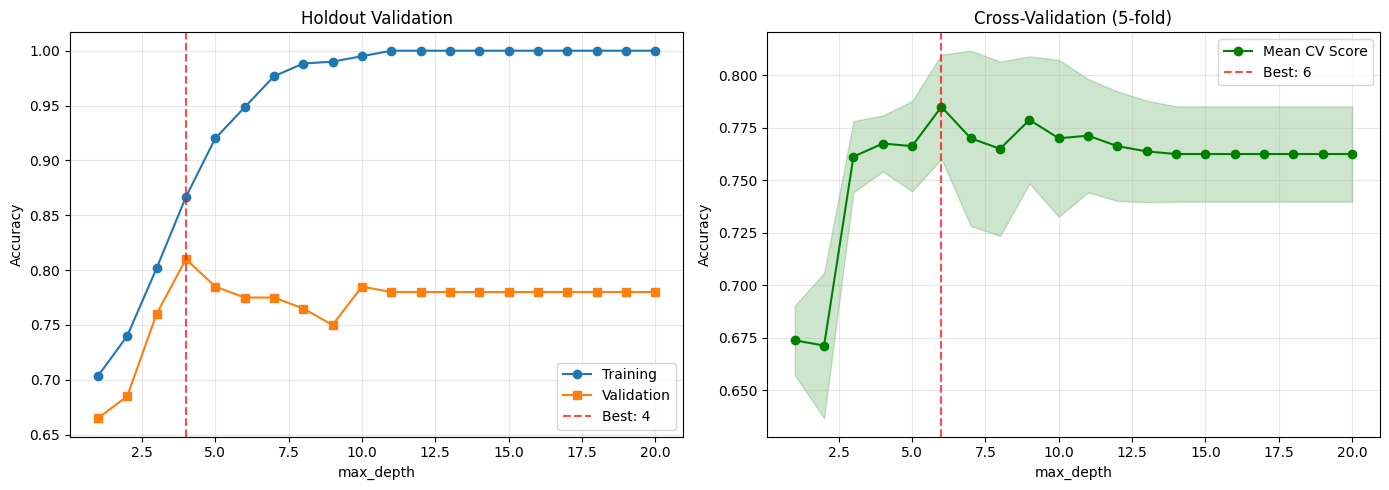

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Holdout Validation
ax1.plot(max_depths, train_scores_holdout, label='Training', marker='o')
ax1.plot(max_depths, val_scores_holdout, label='Validation', marker='s')
ax1.axvline(best_depth_holdout, color='r', linestyle='--', alpha=0.7, label=f'Best: {best_depth_holdout}')
ax1.set_xlabel('max_depth')
ax1.set_ylabel('Accuracy')
ax1.set_title('Holdout Validation')
ax1.legend()
ax1.grid(alpha=0.3)

# Cross-Validation
ax2.plot(max_depths, mean_scores_cv, label='Mean CV Score', marker='o', color='green')
ax2.fill_between(max_depths, 
                  np.array(mean_scores_cv) - np.array(std_scores_cv),
                  np.array(mean_scores_cv) + np.array(std_scores_cv),
                  alpha=0.2, color='green')
ax2.axvline(best_depth_cv, color='r', linestyle='--', alpha=0.7, label=f'Best: {best_depth_cv}')
ax2.set_xlabel('max_depth')
ax2.set_ylabel('Accuracy')
ax2.set_title('Cross-Validation (5-fold)')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Final Evaluation on Test Set

In [8]:
# Retrain on full training data and evaluate on test set
model_holdout = DecisionTreeClassifier(max_depth=best_depth_holdout, random_state=42)
model_holdout.fit(X_train_full, y_train_full)
test_score_holdout = accuracy_score(y_test, model_holdout.predict(X_test))

model_cv = DecisionTreeClassifier(max_depth=best_depth_cv, random_state=42)
model_cv.fit(X_train_full, y_train_full)
test_score_cv = accuracy_score(y_test, model_cv.predict(X_test))

print(f"Test accuracy (Holdout method): {test_score_holdout:.3f}")
print(f"Test accuracy (Cross-Val method): {test_score_cv:.3f}")

Test accuracy (Holdout method): 0.770
Test accuracy (Cross-Val method): 0.790


## Key Takeaways

- **Holdout**: Fast but validation score can vary based on the split
- **Cross-Validation**: More reliable but computationally expensive (5x slower)
- **Best Practice**: Use cross-validation for small datasets, holdout for large ones